In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [39]:
pd.read_csv('coadread_tcga/data_clinical_patient.txt', delimiter='\t').iloc[0:4].transpose()

,0,1,2,3
#Other Patient ID,#Legacy DMP patient identifier (DMPnnnn),#STRING,#1,OTHER_PATIENT_ID
Patient Identifier,Identifier to uniquely specify a patient.,STRING,1,PATIENT_ID
Form completion date,Form completion date,STRING,1,FORM_COMPLETION_DATE
Neoplasm Histologic Type Name,Text term for the structural pattern of cancer...,STRING,1,HISTOLOGICAL_DIAGNOSIS
Tissue Prospective Collection Indicator,Text indicator for the time frame of tissue pr...,STRING,1,PROSPECTIVE_COLLECTION
Tissue Retrospective Collection Indicator,Text indicator for the time frame of tissue pr...,STRING,1,RETROSPECTIVE_COLLECTION
Sex,Sex,STRING,1,SEX
Race Category,The text for reporting information about race.,STRING,1,RACE
Ethnicity Category,The text for reporting information about ethni...,STRING,1,ETHNICITY
Prior Cancer Diagnosis Occurence,Text term to describe the patient's history of...,STRING,1,HISTORY_OTHER_MALIGNANCY


In [40]:
# categorical_features = [col for col in clinical.columns if clinical[col].dtype == 'object']
# for feat in categorical_features:
#     clinical[feat] = pd.Categorical(clinical[feat])
patient = pd.read_csv('coadread_tcga/data_clinical_patient.txt', delimiter='\t', skiprows=4)
print(patient.shape)
patient.replace(['[Not Available]', '[Not Applicable]'], pd.NA, inplace=True)
drop_cols = ['OTHER_PATIENT_ID', 'PATIENT_ID', 'FORM_COMPLETION_DATE', 'PROSPECTIVE_COLLECTION', 'RETROSPECTIVE_COLLECTION', 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS',
             'ICD_10', 'INFORMED_CONSENT_VERIFIED', 'PROJECT_CODE', 'AJCC_NODES_PATHOLOGIC_PN',]
patient.drop(drop_cols, axis=1, inplace=True)

(629, 60)


In [41]:
categorical_features = [col for col in patient.columns if patient[col].dtype == 'object']
for feat in categorical_features:
    print(patient[feat].value_counts())

Colon Adenocarcinoma              392
Rectal Adenocarcinoma             151
Colon Mucinous Adenocarcinoma      62
Rectal Mucinous Adenocarcinoma     13
[Discrepancy]                       3
Name: HISTOLOGICAL_DIAGNOSIS, dtype: int64
Male      335
Female    294
Name: SEX, dtype: int64
WHITE                               296
BLACK OR AFRICAN AMERICAN            65
ASIAN                                12
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: RACE, dtype: int64
NOT HISPANIC OR LATINO    354
HISPANIC OR LATINO          5
Name: ETHNICITY, dtype: int64
No                                                  550
Yes                                                  76
Yes, History of Synchronous/Bilateral Malignancy      1
Name: HISTORY_OTHER_MALIGNANCY, dtype: int64
No     625
Yes      4
Name: HISTORY_NEOADJUVANT_TRTYN, dtype: int64
6th    280
7th    190
5th     85
2nd      1
Name: AJCC_STAGING_EDITION, dtype: int64
T3     428
T2     109
T4      33
T4a     27
T1      20
T4b     10
Tis     

In [42]:
selected_cols = patient.columns[patient.isna().sum() < 5]
selected_cols

Index(['SEX', 'HISTORY_OTHER_MALIGNANCY', 'HISTORY_NEOADJUVANT_TRTYN',
       'INITIAL_PATHOLOGIC_DX_YEAR', 'AJCC_TUMOR_PATHOLOGIC_PT', 'AGE',
       'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'TISSUE_SOURCE_SITE',
       'SITE_OF_TUMOR_TISSUE', 'OS_STATUS', 'OS_MONTHS'],
      dtype='object')

In [43]:
cleaned = patient[selected_cols].dropna().reset_index(drop=True)
cleaned

,SEX,HISTORY_OTHER_MALIGNANCY,HISTORY_NEOADJUVANT_TRTYN,INITIAL_PATHOLOGIC_DX_YEAR,AJCC_TUMOR_PATHOLOGIC_PT,AGE,ICD_O_3_HISTOLOGY,ICD_O_3_SITE,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS
0,Male,No,No,2013,T4a,67,8140/3,C18.2,4N,Colon,0:LIVING,4.8
1,Female,No,No,2013,T3,42,8480/3,C18.6,4T,Colon,0:LIVING,12.65
2,Male,No,No,2009,T3,74,8140/3,C18.2,5M,Colon,1:DECEASED,1.61
3,Female,No,No,2009,T4a,40,8140/3,C18.2,5M,Colon,1:DECEASED,9.53
4,Male,No,No,2011,T3,76,8140/3,C18.2,5M,Colon,0:LIVING,39.42
...,...,...,...,...,...,...,...,...,...,...,...,...
615,Female,No,No,2011,T4a,71,8140/3,C20.9,F5,Rectum,1:DECEASED,11.86
616,Female,No,No,2011,T3,74,8140/3,C20.9,F5,Rectum,0:LIVING,12.45
617,Male,Yes,No,2009,T3,74,8140/3,C20.9,G5,Rectum,1:DECEASED,18.27
618,Male,Yes,No,2007,T3,72,8140/3,C19.9,G5,Rectum,0:LIVING,55.72


In [44]:
cleaned.to_csv('cleaned_clinical.csv', index=False)

In [24]:
cleaned['OS_MONTHS'] = cleaned['OS_MONTHS'].astype('float')
cleaned['OS_MONTHS'].describe()

count    620.000000
mean      27.567629
std       24.754144
min        0.000000
25%       12.442500
50%       21.585000
75%       35.970000
max      147.900000
Name: OS_MONTHS, dtype: float64

In [25]:
cleaned['OS_STATUS'] = cleaned['OS_STATUS'].map({'0:LIVING': 0, '1:DECEASED': 1})
cleaned['OS_STATUS'].value_counts()

0    493
1    127
Name: OS_STATUS, dtype: int64

In [26]:
cleaned.dtypes

SEX                            object
HISTORY_OTHER_MALIGNANCY       object
HISTORY_NEOADJUVANT_TRTYN      object
INITIAL_PATHOLOGIC_DX_YEAR      int64
AJCC_TUMOR_PATHOLOGIC_PT       object
AGE                             int64
ICD_O_3_HISTOLOGY              object
ICD_O_3_SITE                   object
TISSUE_SOURCE_SITE             object
SITE_OF_TUMOR_TISSUE           object
OS_STATUS                       int64
OS_MONTHS                     float64
dtype: object

In [27]:
categorical_features = [col for col in cleaned.columns if cleaned[col].dtype == 'object']
for feat in categorical_features:
    cleaned[feat] = pd.Categorical(cleaned[feat])
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
all_df

,SEX[Male],HISTORY_OTHER_MALIGNANCY[Yes],"HISTORY_OTHER_MALIGNANCY[Yes, History of Synchronous/Bilateral Malignancy]",HISTORY_NEOADJUVANT_TRTYN[Yes],INITIAL_PATHOLOGIC_DX_YEAR,AJCC_TUMOR_PATHOLOGIC_PT[T2],AJCC_TUMOR_PATHOLOGIC_PT[T3],AJCC_TUMOR_PATHOLOGIC_PT[T4],AJCC_TUMOR_PATHOLOGIC_PT[T4a],AJCC_TUMOR_PATHOLOGIC_PT[T4b],...,TISSUE_SOURCE_SITE[NH],TISSUE_SOURCE_SITE[QG],TISSUE_SOURCE_SITE[QL],TISSUE_SOURCE_SITE[RU],TISSUE_SOURCE_SITE[SS],TISSUE_SOURCE_SITE[T9],TISSUE_SOURCE_SITE[WS],SITE_OF_TUMOR_TISSUE[Rectum],OS_STATUS,OS_MONTHS
0,1.0,0.0,0.0,0.0,2013,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.80
1,0.0,0.0,0.0,0.0,2013,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12.65
2,1.0,0.0,0.0,0.0,2009,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.61
3,0.0,0.0,0.0,0.0,2009,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9.53
4,1.0,0.0,0.0,0.0,2011,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,39.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,0.0,0.0,0.0,0.0,2011,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,11.86
616,0.0,0.0,0.0,0.0,2011,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,12.45
617,1.0,1.0,0.0,0.0,2009,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,18.27
618,1.0,1.0,0.0,0.0,2007,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,55.72


In [28]:
all_df.to_csv('clinical_transformed.csv', index=False)

In [29]:
train, test, y_train, _ = train_test_split(all_df, all_df['OS_STATUS'], test_size=0.25, random_state=0)

y_train.value_counts()

0    367
1     98
Name: OS_STATUS, dtype: int64

In [30]:
coxph = CoxPHFitter # shorthand
fit_all = coxph(penalizer=0.05).fit(all_df, 'OS_MONTHS', 'OS_STATUS')

In [33]:
summary = fit_all.summary[['coef', 'se(coef)', 'p']].sort_values('p')
summary.sort_values(by='p')[summary['p'] <=0.05]

,coef,se(coef),p
covariate,,,
AJCC_TUMOR_PATHOLOGIC_PT[T4],1.318083,0.362124,0.000273
AGE,0.023865,0.007469,0.001396
AJCC_TUMOR_PATHOLOGIC_PT[T4a],1.307143,0.427415,0.002226
TISSUE_SOURCE_SITE[5M],1.736135,0.787697,0.027520
TISSUE_SOURCE_SITE[F4],1.121963,0.516640,0.029882
ICD_O_3_HISTOLOGY[8574/3],2.265219,1.129691,0.044945


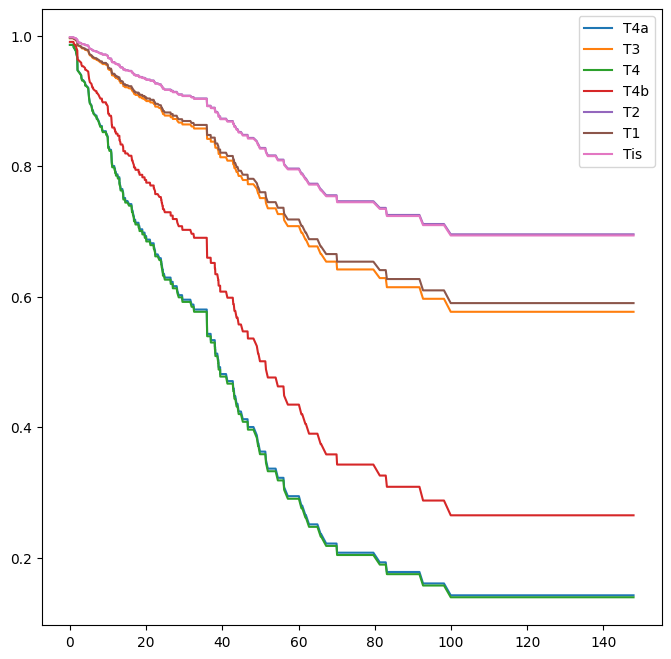

In [34]:
levels = cleaned['AJCC_TUMOR_PATHOLOGIC_PT'].unique()
modal_data = {}
for col in cleaned.columns:
    if cleaned[col].dtype.__str__() == 'category':
        modal_data[col] = pd.Series.mode(cleaned[col])[0]
        
    else:
        modal_data[col] = cleaned[col].mean()

modal_data = pd.DataFrame(data=modal_data, index=[0])
modal_df = pd.DataFrame([modal_data.iloc[0] for _ in range(len(levels))])
modal_df['AJCC_TUMOR_PATHOLOGIC_PT'] = levels
modal_X = all_MS.transform(modal_df)
modal_X.index = levels

predicted_survival = fit_all.predict_survival_function(modal_X)

fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);

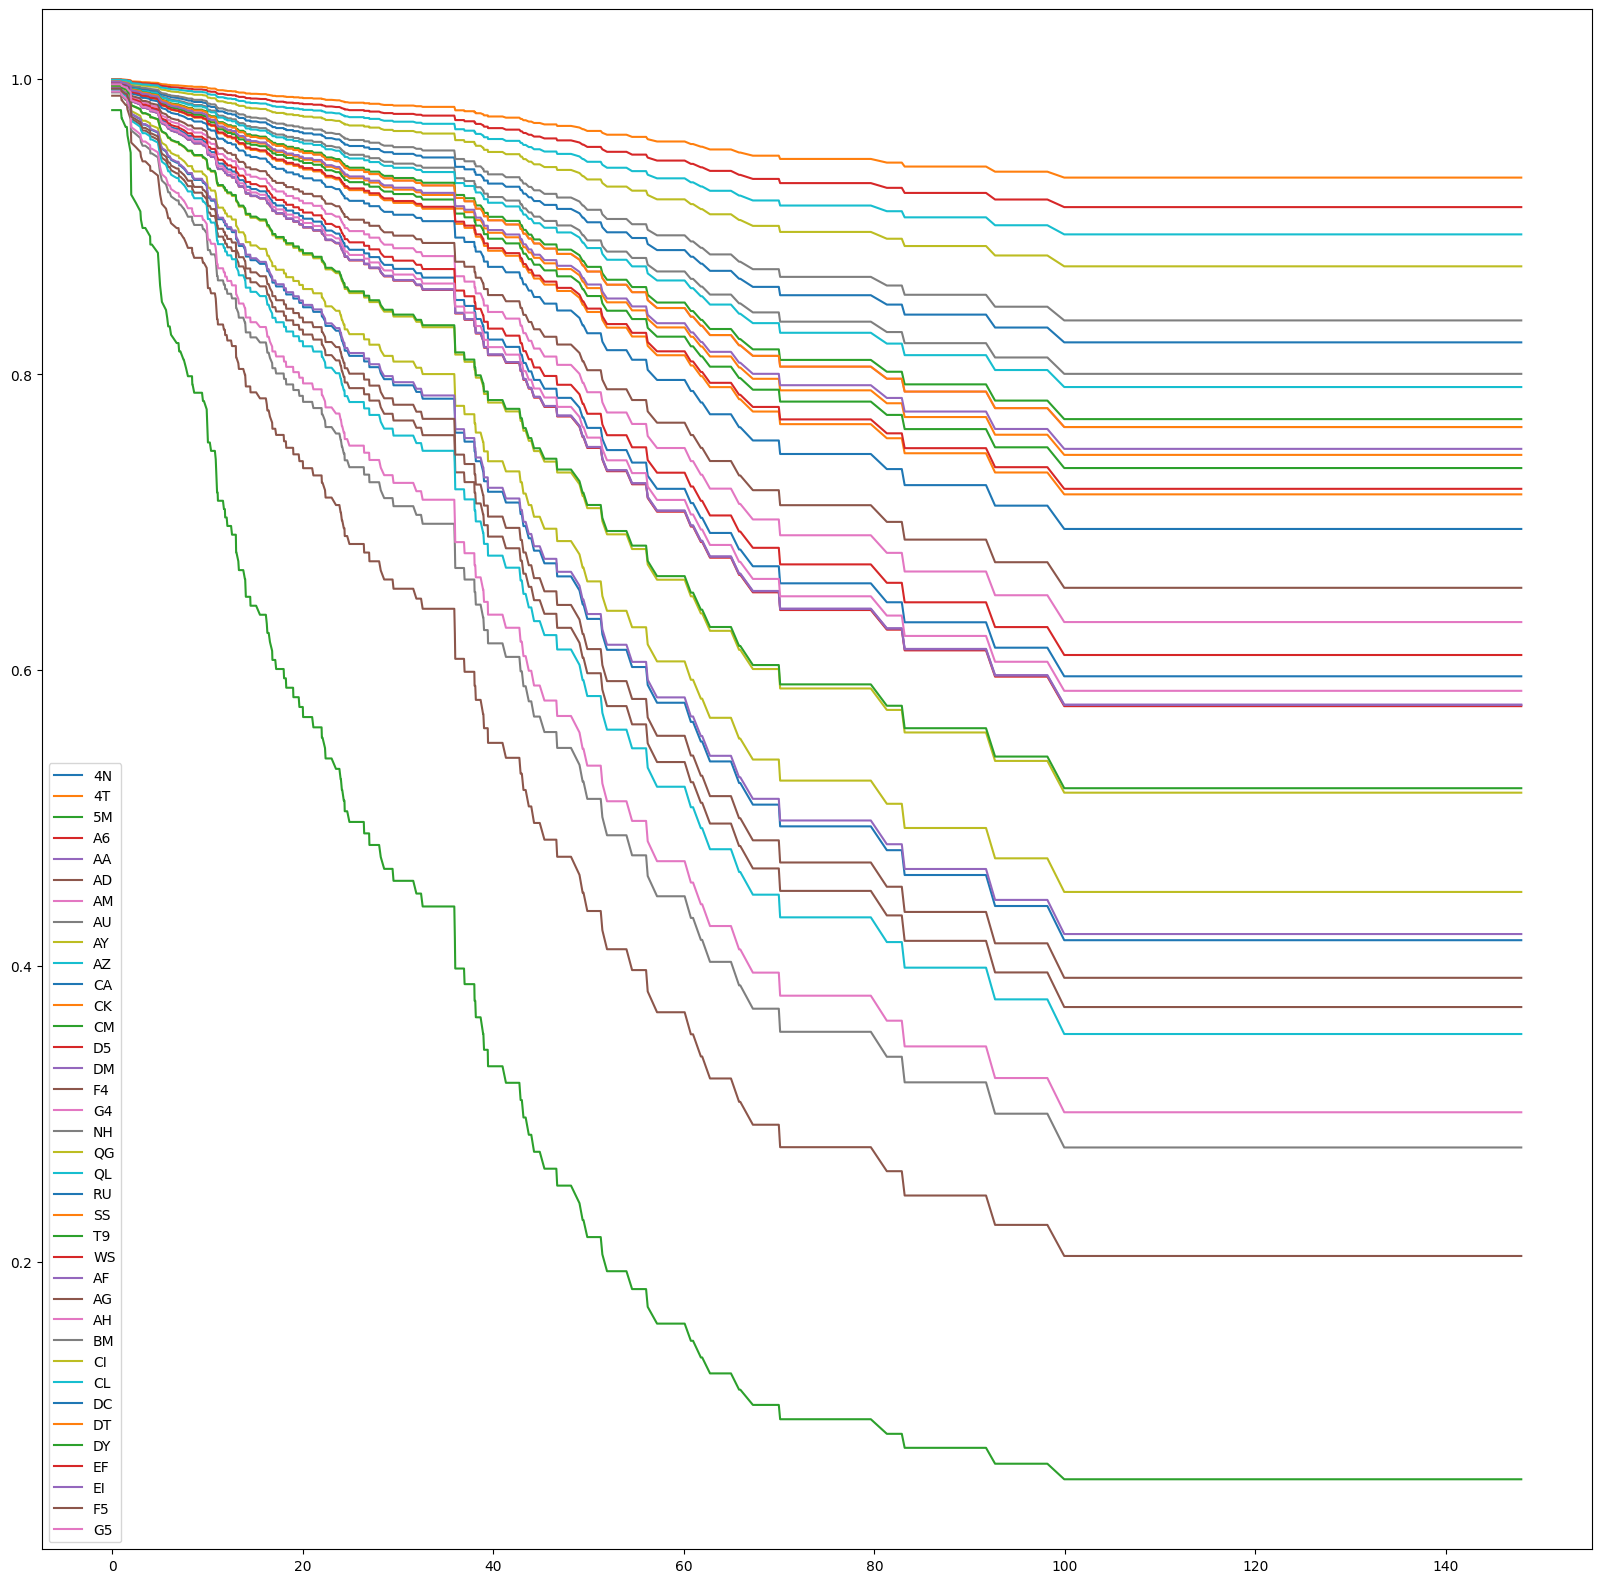

In [37]:
levels = cleaned['TISSUE_SOURCE_SITE'].unique()
modal_data = {}
for col in cleaned.columns:
    if cleaned[col].dtype.__str__() == 'category':
        modal_data[col] = pd.Series.mode(cleaned[col])[0]
        
    else:
        modal_data[col] = cleaned[col].mean()

modal_data = pd.DataFrame(data=modal_data, index=[0])
modal_df = pd.DataFrame([modal_data.iloc[0] for _ in range(len(levels))])
modal_df['TISSUE_SOURCE_SITE'] = levels
modal_X = all_MS.transform(modal_df)
modal_X.index = levels

predicted_survival = fit_all.predict_survival_function(modal_X)

fig, ax = subplots(figsize=(20, 20))
predicted_survival.plot(ax=ax);

In [35]:
predicted_scores = fit_all.predict_expectation(test)
# Compute the C-index
c_index = concordance_index(test['OS_MONTHS'], predicted_scores, test['OS_STATUS'])
print("C-index on the test set:", c_index)

C-index on the test set: 0.7552083333333334


# Classification

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('clinical_transformed.csv')
print(df.columns)
y = df['OS_STATUS'].map({0: 1, 1: 0})
x = df.drop(['OS_STATUS', 'OS_MONTHS'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Models
models = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'DecisionTree': DecisionTreeClassifier()
}

train_results = []
test_results = []

for model_name, model in models.items():
    # Cross-validation on training set
    cv_results = cross_validate(model, x_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    # Train set metrics
    train_avg_accuracy = cv_results['test_accuracy'].mean()
    train_avg_precision = cv_results['test_precision'].mean()
    train_avg_recall = cv_results['test_recall'].mean()
    train_avg_f1 = cv_results['test_f1'].mean()
    train_results.append([model_name, train_avg_accuracy, train_avg_precision, train_avg_recall, train_avg_f1])
    
    # Fit model on the entire training set and predict on test set
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    
    # Test set metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_results.append([model_name, test_accuracy, test_precision, test_recall, test_f1])

# Create dataframes for train and test results
train_results_df = pd.DataFrame(train_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
test_results_df = pd.DataFrame(test_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Save train and test results to CSV files
train_results_df.to_csv('train_clinical_classification_results.csv', index=False)
test_results_df.to_csv('test_clinical_classification_results.csv', index=False)